### Exploratory Data Analysis for Movie data -- Part 1

### *Preprocess the Data*

In [1]:
# Make the chunk output all results not only the last result
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Import libraries
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')
from nltk.util import ngrams
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import ast

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hongyang.zheng\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Load data
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

# Look at the data
train.head(10)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970
5,6,NaN,8000000,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",NaN,tt0093743,en,Pinocchio and the Emperor of the Night,"Pinocchio and his friends, a glow worm and a m...",0.743274,/6IDqA1D2NBIVhzEEaMMRL28iBrq.jpg,NaN,NaN,8/6/87,83.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Pinocchio and the Emperor of the Night,NaN,"[{'cast_id': 6, 'character': 'Pinocchio (voice...","[{'credit_id': '52fe46f49251416c9106558b', 'de...",3261638
6,7,NaN,14000000,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",http://www.thepossessionmovie.com/,tt0431021,en,The Possession,A young girl buys an antique box at a yard sal...,7.286477,/4QjzFuaZmB4btGnLwAgdp23BzIU.jpg,"[{'name': 'Ghost House Pictures', 'id': 768}, ...","[{'iso_3166_1': 'US', 'name': 'United States o...",8/30/12,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Fear The Demon That Doesn't Fear God,The Possession,NaN,"[{'c

In [4]:
# Look at the shape of train data
train.shape

# Look at the shape of test data
test.shape

(3000, 23)

(4398, 22)

The train dataset only has 3000 observations, which is smaller than the test dataset. I think this will make training an accurate model much harder.

In [5]:
# Print out the columns name
train.columns.values

array(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'Keywords',
       'cast', 'crew', 'revenue'], dtype=object)

### Preprocess columns

They are `belongs_to_collection`, `genres`, `production_companies`, `production_countries`, `spoken_languages`, `Keywords`, `cast` and `crew`.

First convert some json columns into dictionaries.


In [6]:
# Write a function to do this for both train and test dataset
def convert_json(df):
    columns_need_convert=['belongs_to_collection', 'genres', 'production_companies',
                          'production_countries', 'spoken_languages', 'Keywords', 
                          'cast', 'crew']
    for name in columns_need_convert:
        df[name]=df[name].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x))
    
    return(df)

train=convert_json(train)
test=convert_json(test)

Some columns have one or more dictionaries, so the first step is to extract meaningful values from it.
#### *belongs_to_collection*

In [7]:
# Look at this column
train.belongs_to_collection.head()

0    [{'id': 313576, 'name': 'Hot Tub Time Machine ...
1    [{'id': 107674, 'name': 'The Princess Diaries ...
2                                                   {}
3                                                   {}
4                                                   {}
Name: belongs_to_collection, dtype: object

In [8]:
# Create a new column to store the name of the collection
train['collection']=train["belongs_to_collection"].apply(lambda x: x[0]['name'] if x!={} else np.nan)
test['collection']=test["belongs_to_collection"].apply(lambda x: x[0]['name'] if x!={} else np.nan)

# Other operations
train['n_collection']=train["belongs_to_collection"].apply(lambda x: len(x) if x!={} else 0)
test['n_collection']=test["belongs_to_collection"].apply(lambda x: len(x) if x!={} else 0)

In [9]:
# Look at the new columns
train.collection.head()
train.n_collection.head()

# Count the collection
sum(train.n_collection)
len(train)-sum(train.n_collection)

0    Hot Tub Time Machine Collection
1    The Princess Diaries Collection
2                                NaN
3                                NaN
4                                NaN
Name: collection, dtype: object

0    1
1    1
2    0
3    0
4    0
Name: n_collection, dtype: int64

604

2396

#### *genres*

In [10]:
# Look at this column
train.genres.head()

0                       [{'id': 35, 'name': 'Comedy'}]
1    [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
2                        [{'id': 18, 'name': 'Drama'}]
3    [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...
4    [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...
Name: genres, dtype: object

In [11]:
# Some observations have more than one genres
for ele in train.genres[1]:
    print(ele['name'])

Comedy
Drama
Family
Romance


In [12]:
# Create a new column to store all genres
train['pure_genres']=train["genres"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)
test['pure_genres']=test["genres"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)

# Count the genres
train['n_genres']=train["genres"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)
test['n_genres']=test["genres"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)

In [13]:
# Look at the new column
train['pure_genres'].head()
train['n_genres'].head()

0                            [Comedy]
1    [Comedy, Drama, Family, Romance]
2                             [Drama]
3                   [Thriller, Drama]
4                  [Action, Thriller]
Name: pure_genres, dtype: object

0    1
1    4
2    1
3    2
4    2
Name: n_genres, dtype: int64

In [14]:
print('Number of genres')
types=pd.DataFrame(train['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts())
types.columns=["# of Movie"]
types

Number of genres


,# of Movie
2,972
3,900
1,593
4,393
5,111
6,21
0,7
7,3


#### There are outliers! 
For example, there are 7 movies having 0 genres, which is impossible; also there are 3 movies having 7 genres, which is too many. Usually, 1-4 is a normal range.

In [15]:
# Make a genres list
genres_list = list(train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

# Count for each genres
genres=pd.DataFrame(Counter([i for j in genres_list for i in j]).most_common())
genres.columns = ['genres', 'number']
genres

,genres,number
0,Drama,1531
1,Comedy,1028
2,Thriller,789
3,Action,741
4,Romance,571
5,Crime,469
6,Adventure,439
7,Horror,301
8,Science Fiction,290
9,Family,260


For now, I am not sure how to deal with this column. I have several ideas:

1. mark the movie with top n popular genres
2. mark the movie with more than n genres
3. use the number of genres as a numerical column

Also I need to deal with the outlier. 

Let's come back later.

#### *production_companies*

In [16]:
# Look at this column
train.production_companies.head()

0    [{'name': 'Paramount Pictures', 'id': 4}, {'na...
1          [{'name': 'Walt Disney Pictures', 'id': 2}]
2    [{'name': 'Bold Films', 'id': 2266}, {'name': ...
3                                                   {}
4                                                   {}
Name: production_companies, dtype: object

In [17]:
# Create a new column to store all company
train['company']=train["production_companies"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)
test['company']=test["production_companies"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)

# Count the number of company
train['n_company']=train["production_companies"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)
test['n_company']=test["production_companies"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)

In [18]:
# Look at the new column
train['company'].head()
train['n_company'].head()

0    [Paramount Pictures, United Artists, Metro-Gol...
1                               [Walt Disney Pictures]
2    [Bold Films, Blumhouse Productions, Right of W...
3                                                  NaN
4                                                  NaN
Name: company, dtype: object

0    3
1    1
2    3
3    0
4    0
Name: n_company, dtype: int64

In [19]:
# Summary of the number of company
print("The number of Company:")
print(train['n_company'].value_counts())

The number of Company:
1     775
2     734
3     582
4     312
5     166
0     156
6     118
7      62
8      42
9      29
11      7
10      7
12      3
16      2
15      2
14      1
13      1
17      1
Name: n_company, dtype: int64


#### There are outliers !
0 company and more than 10 companies are not reasonable.

Let's look at which companies the train dataset has:

In [20]:
# For every possible combination
company_comb_list = pd.DataFrame(train["company"].value_counts())
company_comb_list.columns=["Count"]
company_comb_list[:10]
company_comb_list[-10:]

,Count
[Paramount Pictures],51
[Universal Pictures],36
[Metro-Goldwyn-Mayer (MGM)],32
[Warner Bros.],32
[Twentieth Century Fox Film Corporation],24
[New Line Cinema],17
[Touchstone Pictures],17
[Columbia Pictures],17
[TriStar Pictures],16
[Walt Disney Pictures],12


,Count
"[Pt. Merantau Films, XYZ Films]",1
"[Rai Cinema, Redwave Films, Protagonist Pictures, 19 Entertainment]",1
[TNT],1
"[Jensen Farley Pictures, Barry & Enright Productions]",1
[Gaumont],1
"[Indian Paintbrush, Super Crispy Entertainment]",1
"[Happy Madison Productions, Karz Entertainment, Warner Bros., Gulfstream Pictures]",1
"[Columbia Pictures Corporation, Beacon Communications, Radiant Productions]",1
"[Paramount Pictures, Columbus Circle Films]",1
"[Lakeshore Entertainment, Sidney Kimmel Entertainment, Sierra/Affinity]",1


In [21]:
# For every single company
# Cannot directly use train['company'], because for that one we set 'np.nan' rather than "[]"
company_list = list(train['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

# Count for each genres
company_list=pd.DataFrame(Counter([i for j in company_list for i in j]).most_common())
company_list.columns = ['company', 'number']
company_list.head(20)

,company,number
0,Warner Bros.,202
1,Universal Pictures,188
2,Paramount Pictures,161
3,Twentieth Century Fox Film Corporation,138
4,Columbia Pictures,91
5,Metro-Goldwyn-Mayer (MGM),84
6,New Line Cinema,75
7,Touchstone Pictures,63
8,Walt Disney Pictures,62
9,Columbia Pictures Corporation,61


Let's look up the top 10 movie production companies in the world for 2019:

1. Time Warner
2. Sony
3. The Walt Disney Company
4. NBC Universal
5. 21st Century Fox
6. Viacom
7. Lions Gate Entertainment
8. The Weinstein Company
9. MGM
10. Dream Works
 
Some production companies have multiple sub-companies. So in general, I select several companies based on this list and the companies in our dataset, they are: `Paramount Pictures(Viacom)`, `Universal Pictures(NBC Universal)`, `Metro-Goldwyn-Mayer (MGM)`, `Warner Bros.(Time Warner)`,  `Twentieth Century Fox Film Corporation(21st Century Fox)`, `New Line Cinema(Time Warner)`, `Touchstone Pictures(The Walt Disney Company)`, `Columbia Pictures(Sony)`, `TriStar Pictures(Sony)`, `Walt Disney Pictures(The Walt Disney Company)`, `Columbia Pictures Corporation(Sony)`, `Hollywood Pictures(The Walt Disney Company)`

From above list we can see that the top 10 companies cover about 10% of all the movies. If it covers too many, it may be meaningless to figure out whether a movie is produced by one of the top 10 companies. 

I am not sure how to deal with this, and have several ideas:
1. mark the movie that is produced by the ratio of total top company/total company
2. mark the movie if it is produced by at least one top company
3. mark the movie that is produced by the ratio of total top n company/total company (most frequent)
4. mark the movie that is produced by the ratio of joint top company/total company

The company list may be subjective, so I need to think about it and come back to this part later.

#### *production_countries*

In [22]:
# Create a new column to store all countries
train['country']=train["production_countries"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)
test['country']=test["production_countries"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)

# Count the countries
train['n_country']=train["production_countries"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)
test['n_country']=test["production_countries"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)

In [23]:
# Look at the new columns
train['country'].head()
train['n_country'].head()

# Outliers: production country cannot be 0
len(train[train['n_country']==0])

0    [United States of America]
1    [United States of America]
2    [United States of America]
3                       [India]
4                 [South Korea]
Name: country, dtype: object

0    1
1    1
2    1
3    1
4    1
Name: n_country, dtype: int64

55

In [42]:
# Create a column if the movie is produced by two or more countries
train[">1_country"]=train["n_country"].apply(lambda x: 1 if x>1 else 0)
test[">1_country"]=test["n_country"].apply(lambda x: 1 if x>1 else 0)

# Look at the head
train['>1_country'].value_counts()

0    2277
1     723
Name: >1_country, dtype: int64

#### *spoken_languages*

In [25]:
# Create a new column to store all languages
train['language']=train["spoken_languages"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)
test['language']=test["spoken_languages"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)

# Count the languages
train['n_lan']=train["spoken_languages"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)
test['n_lan']=test["spoken_languages"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)

In [26]:
# Look at these new columns
train["language"].head()
train["n_lan"].head()

# Count the freq for each unique language
lan_list = list(train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

# Count for each genres
lan_list=pd.DataFrame(Counter([i for j in lan_list for i in j]).most_common())
lan_list.columns = ['language', 'number']
lan_list.head()

# Outliers: the spoken language cannot be 0
sum(train['n_lan']==0)

0            [English]
1            [English]
2            [English]
3    [English, हिन्दी]
4            [한국어/조선말]
Name: language, dtype: object

0    1
1    1
2    1
3    2
4    1
Name: n_lan, dtype: int64

,language,number
0,English,2618
1,Français,288
2,Español,239
3,Deutsch,169
4,Pусский,152


20

#### *Keywords*

In [27]:
# Create a new column to store all keywords
train['word']=train["Keywords"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)
test['word']=test["Keywords"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)

# Look at this column
train['word'].head()

0    [time travel, sequel, hot tub, duringcreditsst...
1        [coronation, duty, marriage, falling in love]
2    [jazz, obsession, conservatory, music teacher,...
3    [mystery, bollywood, police corruption, crime,...
4                                                  NaN
Name: word, dtype: object

In [28]:
# Create a column with the number of keywords in a movie
# This variable may reflect the diversity of this movie
train["word_div"]=train["Keywords"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)
test["word_div"]=test["Keywords"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)

# Look at this column
train["word_div"].head()
train["word_div"].value_counts()

0     4
1     4
2    12
3     7
4     0
Name: word_div, dtype: int64

5      293
0      276
4      248
3      228
6      227
2      207
7      192
1      187
8      161
9      134
11     132
10     125
12     100
13      85
14      59
15      59
16      58
17      45
18      29
20      24
21      23
19      22
22      17
23      15
24      12
27      12
25       6
26       5
32       2
28       2
30       2
31       2
29       2
37       2
43       1
40       1
38       1
33       1
97       1
39       1
149      1
Name: word_div, dtype: int64

In [29]:
# Create a keywords list
words_list=list(train['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Top Keywords')

(-0.5, 1199.5, 999.5, -0.5)

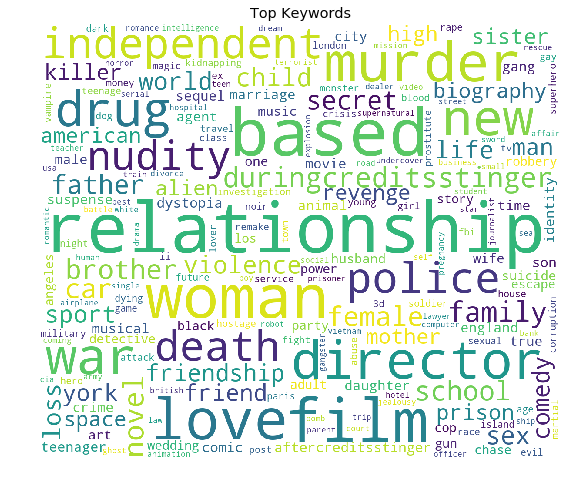

In [30]:
# Create a word cloud for the keywords list
plt.figure(figsize = (12, 8))
text = ' '.join([i for j in words_list for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top Keywords')
plt.axis("off")
plt.show()

#### *crew*

In [31]:
# Create a new column to store all crews
train['Crew']=train["crew"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)
test['Crew']=test["crew"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)

# Create a new column to store the number of crews
train["n_crew"]=train["crew"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)
test["n_crew"]=test["crew"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)

In [32]:
# Look at the new columns
train['Crew'].head()
train['n_crew'].head()

# Count the freq
train['n_crew'].value_counts()[:10]

0    [Kelly Cantley, Steve Pink, Josh Heald, Josh H...
1    [Garry Marshall, Charles Minsky, John Debney, ...
2    [Terri Taylor, Richard Henderson, Jeffrey Stot...
3              [Sujoy Ghosh, Sujoy Ghosh, Sujoy Ghosh]
4                     [Jong-seok Yoon, Jong-seok Yoon]
Name: Crew, dtype: object

0    72
1     9
2    64
3     3
4     2
Name: n_crew, dtype: int64

2     179
11    127
10    126
3     126
12    110
9     109
8     109
14    104
4     101
7      94
Name: n_crew, dtype: int64

We can see that most movies have 2-14 crews.

In [33]:
# Create a crew list
initial_list=list(train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
train['initial_crew']=train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
crew_list=Counter([i for j in initial_list for i in j]).most_common()

# Create top 1% crew list
n=len(crew_list)*0.01
# Select top 400 crew
common_crew=crew_list[:400]
common_crew[:20]

# Convert to a list
top_crew=[i[0] for i in common_crew]

[('Avy Kaufman', 50),
 ('Robert Rodriguez', 44),
 ('Deborah Aquila', 40),
 ('James Newton Howard', 39),
 ('Mary Vernieu', 38),
 ('Steven Spielberg', 37),
 ('Luc Besson', 37),
 ('Jerry Goldsmith', 37),
 ('Francine Maisler', 35),
 ('Tricia Wood', 35),
 ('James Horner', 33),
 ('Kerry Barden', 32),
 ('Bob Weinstein', 30),
 ('Harvey Weinstein', 30),
 ('Janet Hirshenson', 30),
 ('Jane Jenkins', 29),
 ('John Debney', 28),
 ('Hans Zimmer', 28),
 ('John Papsidera', 28),
 ('Francis Ford Coppola', 28)]

In [34]:
# Create a column to contain the number of top crew 
def count_var_1(row, top_list):
    count=0
    for ele in row["initial_crew"]:
        if ele in top_list:
            count+=1      
    return(count)

# Create a column to contain the ratio between the number of top crew and the total number of crew
def ratio_var_1(row, top_list):
    if row["n_crew"]==0:
        ratio=np.nan
    else:
        ratio=count_var_1(row, top_list)/(row["n_crew"])
    return(ratio)
    
# New columns
train['crew_top']=train.apply(lambda row: count_var_1(row, top_crew), axis=1)
train['crew_top'].value_counts()

train['crew_top_ratio']=train.apply(lambda row: ratio_var_1(row, top_crew), axis=1)
train['crew_top_ratio'].head()

0     1309
1      432
2      330
3      268
4      185
5      145
6       95
7       70
8       48
9       38
10      21
11      19
12      16
13       9
15       5
14       5
16       3
19       1
18       1
Name: crew_top, dtype: int64

0    0.013889
1    0.222222
2    0.046875
3    0.000000
4    0.000000
Name: crew_top_ratio, dtype: float64

In [35]:
# Same process for test data
# Create a crew list
initial_list_2=list(test['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
test['initial_crew']=test['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
crew_list_2=Counter([i for j in initial_list_2 for i in j]).most_common()

# Create top 1% crew list
n=len(crew_list_2)*0.01
n
# Select top 500 crew
common_crew_2=crew_list_2[:500]

# Convert to a list
top_crew_2=[i[0] for i in common_crew_2]

test['crew_top']=test.apply(lambda row: count_var_1(row, top_crew_2), axis=1)
test['crew_top_ratio']=test.apply(lambda row: ratio_var_1(row, top_crew_2), axis=1)

499.81

#### *cast*

In [36]:
# Create a new column to store all casts
train['Cast']=train["cast"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)
test['Cast']=test["cast"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)

# Create a new column to store the number of casts
train["n_cast"]=train["cast"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)
test["n_cast"]=test["cast"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)

In [37]:
# Look at the new columns
train['Cast'].head()
train['n_cast'].head()

# Count the freq
train['n_cast'].value_counts()[:10]

0    [Rob Corddry, Craig Robinson, Clark Duke, Adam...
1    [Anne Hathaway, Julie Andrews, H√©ctor Elizond...
2    [Miles Teller, J.K. Simmons, Melissa Benoist, ...
3    [Vidya Balan, Nawazuddin Siddiqui, Parambrata ...
4    [Kim Kang-woo, Jo Jae-hyeon, Park Si-yeon, Kim...
Name: Cast, dtype: object

0    24
1    20
2    51
3     7
4     4
Name: n_cast, dtype: int64

15    212
16    165
10    135
13    129
12    124
11    122
9     118
17    118
18    115
14    110
Name: n_cast, dtype: int64

Most movies have 9-20 casts

In [38]:
# Create a cast list
cast_list=list(train['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
train['initial_cast']=train['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
cast_list=Counter([i for j in cast_list for i in j]).most_common()

# Create top 1% cast list
l=len(cast_list)*0.01
# Select top 400 cast
common_cast=cast_list[:400]
common_cast[:20]

# Convert to a list
top_cast=[i[0] for i in common_cast]

[('Samuel L. Jackson', 30),
 ('Robert De Niro', 30),
 ('Morgan Freeman', 27),
 ('J.K. Simmons', 25),
 ('Bruce Willis', 25),
 ('Liam Neeson', 25),
 ('Susan Sarandon', 25),
 ('Bruce McGill', 24),
 ('John Turturro', 24),
 ('Forest Whitaker', 23),
 ('Willem Dafoe', 23),
 ('Bill Murray', 22),
 ('Owen Wilson', 22),
 ('Nicolas Cage', 22),
 ('Sylvester Stallone', 21),
 ('Jason Statham', 21),
 ('Keith David', 21),
 ('John Goodman', 21),
 ('Mel Gibson', 21),
 ('Sigourney Weaver', 21)]

In [39]:
# Create a column to contain the number of top cast
def count_var_2(row, top_list):
    count=0
    for ele in row["initial_cast"]:
        if ele in top_list:
            count+=1      
    return(count)

# Create a column to contain the ratio between the number of top cast and the total number of cast
def ratio_var_2(row, top_list):
    if row["n_cast"]==0:
        ratio=np.nan
    else:
        ratio=count_var_2(row, top_list)/(row["n_cast"])
    return(ratio)
    
# New columns
train['cast_top']=train.apply(lambda row: count_var_2(row, top_cast), axis=1)
train['cast_top'].value_counts()

train['cast_top_ratio']=train.apply(lambda row: ratio_var_2(row, top_cast), axis=1)
train['cast_top_ratio'].head()

0     1084
1      574
2      480
3      331
4      219
5      142
6       85
7       53
8       14
9        8
10       6
11       2
15       1
13       1
Name: cast_top, dtype: int64

0    0.125000
1    0.200000
2    0.019608
3    0.000000
4    0.000000
Name: cast_top_ratio, dtype: float64

In [40]:
# Same process for test data
# Create a cast list
cast_list_2=list(test['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
test['initial_cast']=test['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
cast_list_2=Counter([i for j in cast_list_2 for i in j]).most_common()

# Create top 1% cast list
n=len(cast_list_2)*0.01
n
# Select top 532 cast
common_cast_2=cast_list_2[:532]

# Convert to a list
top_cast_2=[i[0] for i in common_cast_2]

test['cast_top']=test.apply(lambda row: count_var_2(row, top_cast_2), axis=1)
test['cast_top_ratio']=test.apply(lambda row: ratio_var_2(row, top_cast_2), axis=1)

531.75

In [43]:
# Write out to a csv to store the new dataset 
train.to_csv("1_new_train.csv", index=False)
test.to_csv("1_new_test.csv", index=False)